In [2]:
from sqlalchemy import create_engine, inspect
from sklearn_pandas import DataFrameMapper
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import psycopg2
import numpy as np
from collections import Counter
import json


In [58]:
PSQL = 'postgres://{}@localhost:5432/rpred'

cred = ""
with open("../credentials/localhost/jessica.txt") as credfile:
    cred = credfile.read().strip("\n")

cnx = create_engine(PSQL.format(cred), isolation_level='AUTOCOMMIT')

In [59]:
df8 = pd.read_sql_query('''SELECT * FROM yelp_dataset_8''', cnx)
df11 = pd.read_sql_query('''SELECT business_id FROM yelp_dataset_11''', cnx)

print(len(df8))
print(len(df11))


df8.neighborhoods.unique()
df8.head(2)

15365
34045


,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
0,5UmKMjUEUNdYWqANhGckJw,4734 Lebanon Church Rd\nDravosburg PA 15034,{'Friday': {'close': '21:00' 'open': '11:00'}...,True,['Fast Food' 'Restaurants'],Dravosburg,7,Mr Hoagie,[],-79.900706,PA,3.5,40.354327,{'Take-out': True 'Drive-Thru': False 'Good ...,business
1,yXuao0pFz1AxB21vJjDf5w,2100 Washington Pike\nCarnegie PA 15106,{'Monday': {'close': '00:00' 'open': '00:00'}...,True,['Food' 'Grocery'],Carnegie,5,Shop N' Save,[],-80.093215,PA,4.0,40.387512,{'Parking': {'garage': False 'street': False ...,business


In [68]:
join = []
for v in df8.business_id.values:
    if v in df11.business_id.values:
        join.append(v)
print(len(join))

0


In [30]:
addr = "4734 Lebanon Church Rd\nDravosburg PA 15034"

import re

def extract_zip(addr):
    m = re.search("(\w)+$", addr)
    if m:
        return m.group(0)
    return None

df8['zip'] = df8['full_address'].apply(extract_zip)
df8.head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type,zip
0,5UmKMjUEUNdYWqANhGckJw,4734 Lebanon Church Rd\nDravosburg PA 15034,{'Friday': {'close': '21:00' 'open': '11:00'}...,True,['Fast Food' 'Restaurants'],Dravosburg,7,Mr Hoagie,[],-79.900706,PA,3.5,40.354327,{'Take-out': True 'Drive-Thru': False 'Good ...,business,15034
1,yXuao0pFz1AxB21vJjDf5w,2100 Washington Pike\nCarnegie PA 15106,{'Monday': {'close': '00:00' 'open': '00:00'}...,True,['Food' 'Grocery'],Carnegie,5,Shop N' Save,[],-80.093215,PA,4.0,40.387512,{'Parking': {'garage': False 'street': False ...,business,15106
2,zaXDakTd3RXyOa7sMrUE1g,202 3rd Ave\nCarnegie\nCarnegie PA 15106,{'Monday': {'close': '14:00' 'open': '07:00'}...,True,['Cafes' 'Restaurants'],Carnegie,9,Barb's Country Junction Cafe,['Carnegie'],-80.089985,PA,4.0,40.404638,{'Take-out': True 'Good For': {'dessert': Fal...,business,15106
3,8QlnAcjGE6dgfKTVoxrPvQ,300 Davis Blvd\nEtna\nPittsburgh PA 15275,{'Monday': {'close': '22:00' 'open': '10:30'}...,True,['American (Traditional)' 'Comfort Food' 'Ca...,Pittsburgh,3,Boston Market,['Etna'],-79.958717,PA,2.5,40.495167,{'Take-out': True 'Wi-Fi': 'no' 'Alcohol': '...,business,15275
4,PK6aSizckHFWk8i0oxt5DA,400 Waterfront Dr E\nHomestead\nHomestead PA ...,{},True,['Burgers' 'Fast Food' 'Restaurants'],Homestead,12,McDonald's,['Homestead'],-79.909886,PA,2.0,40.412012,{'Take-out': True 'Wi-Fi': 'free' 'Drive-Thr...,business,15120


In [32]:
df8[df8['zip'] == '2G6']

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type,zip
15360,m1sb0KxX6wjr1gdA0bCTvg,225 Rue Peel\nSud-Ouest\nMontréal QC H3C 2G6,{'Monday': {'close': '22:00' 'open': '09:00'}...,True,['Food' 'Grocery'],Montréal,3,Marché Adonis,['Sud-Ouest'],-73.558793,QC,2.5,45.494169,{'Take-out': False 'Parking': {'garage': Fals...,business,2G6


In [54]:
zip_df = pd.read_csv("../data/raw_data/us-income-stats/kaggle_income.csv", encoding = "latin-1")
#print(zip_df.columns)

#zip_df = df[['Zip_Code', 'City', 'Mean', 'Median']]
#zip_df.head()
#zip_dict = zip_df.set_index('Zip_Code').to_dict(orient='dict')  # Zip code -> stuff
#zip_dict['Median']
zip_df = zip_df.groupby(by=['State_Name', 'City', 'Zip_Code']).mean()[['Median']].reset_index()
zip_df.head()

,State_Name,City,Zip_Code,Median
0,Alabama,Abbeville,36310,25216.000000
1,Alabama,Adamsville,35005,47460.000000
2,Alabama,Alabaster,35007,149711.333333
3,Alabama,Albertville,35950,20717.000000
4,Alabama,Albertville,35951,300000.000000


In [55]:
print(len(zip_df['Zip_Code'].unique()))
print(len(zip_df))

14803
15389


In [33]:
df8['median_income'] = np.where(df8['zip'] == zip_df['Zip_Code'], zip_df['Median'], None)
df8.head()

ValueError: Can only compare identically-labeled Series objects

# [Categories](#categories)
# [Attributes](#attributes)
# [Hours](#hours)
# [Example Json](#example)

In [16]:
zip_df[zip_df['Zip_Code'] == 15106]

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
24273,42012116,42,Pennsylvania,PA,Allegheny County,Carnegie,Carnegie,Borough,place,15106,412,4190355,0,40.407968,-80.08602,55601,40791,54042,2458.312727


 <a class="anchor" id="categories"></a>
# Find most popular category keywords:

In [2]:
category_keywords = ['sandwiches', 'fast food', 'nightlife', 'pizza', 'bars',
                     'mexican', 'food', 'american', 'burgers', 'chinese',
                     'italian', 'breakfast & brunch', 'thai', 'indian',
                     'sushi', 'korean', 'mediterranean', 'japanese', 'seafood',
                     'middle eastern', 'pakistani', 'barbeque', 'vietnamese',
                     'asian fusion', 'diners', 'greek', 'vegetarian', 'cafes',
                    'comfort food', 'bakeries']
    
df_c = pd.read_sql_query('''SELECT business_id, categories FROM yelp_dataset_8''', cnx)

df_c.head()

,business_id,categories
0,5UmKMjUEUNdYWqANhGckJw,['Fast Food' 'Restaurants']
1,yXuao0pFz1AxB21vJjDf5w,['Food' 'Grocery']
2,zaXDakTd3RXyOa7sMrUE1g,['Cafes' 'Restaurants']
3,8QlnAcjGE6dgfKTVoxrPvQ,['American (Traditional)' 'Comfort Food' 'Ca...
4,PK6aSizckHFWk8i0oxt5DA,['Burgers' 'Fast Food' 'Restaurants']


In [3]:
df_c['categories'] = df_c.categories.str.lower()
df_c.head()

,business_id,categories
0,5UmKMjUEUNdYWqANhGckJw,['fast food' 'restaurants']
1,yXuao0pFz1AxB21vJjDf5w,['food' 'grocery']
2,zaXDakTd3RXyOa7sMrUE1g,['cafes' 'restaurants']
3,8QlnAcjGE6dgfKTVoxrPvQ,['american (traditional)' 'comfort food' 'ca...
4,PK6aSizckHFWk8i0oxt5DA,['burgers' 'fast food' 'restaurants']


In [4]:
keyword_count = {}
for keyword in category_keywords:
    count = len(df_c[df_c.categories.str.contains(keyword)])
    keyword_count[keyword] = count
    
sorted(keyword_count.items(), key=lambda x: x[1], reverse=True)

[('food', 13486),
 ('fast food', 3154),
 ('sandwiches', 1220),
 ('bakeries', 1203),
 ('cafes', 1127),
 ('burgers', 963),
 ('bars', 901),
 ('mexican', 837),
 ('american', 808),
 ('breakfast & brunch', 622),
 ('nightlife', 408),
 ('chinese', 270),
 ('pizza', 206),
 ('italian', 148),
 ('seafood', 110),
 ('mediterranean', 103),
 ('comfort food', 101),
 ('barbeque', 72),
 ('vegetarian', 71),
 ('asian fusion', 61),
 ('thai', 59),
 ('diners', 58),
 ('indian', 55),
 ('greek', 55),
 ('japanese', 54),
 ('middle eastern', 54),
 ('vietnamese', 31),
 ('korean', 30),
 ('sushi', 28),
 ('pakistani', 8)]

## Top 10 interesting keywords:
1. ('fast food', 3154),
2. ('burgers', 963),
3. ('bars', 901),
4. ('mexican', 837),
5. ('american', 808),
6. ('chinese', 270),
7. ('pizza', 206),
8. ('italian', 148),
9. ('seafood', 110),
10. ('mediterranean', 103),

# TODO: Create SQL table for categories.

In [61]:
json_str = ""
with open("../data/yelp8/yelp_academic_dataset_business.json") as file:
    json_str = file.read()

In [62]:
att = []
hours = []
for item in json_str.split("\n"):
    if item.find("'Restaurants'") > 0 or item.find("Food") > 0 or item.find("Cafe") > 0 or item.find("Bakeries") > 0:
        item = json.loads(item)
        att.append(item['attributes'])
        hours.append(item['hours'])

 <a class="anchor" id="attributes"></a>
# Attributes
* Good for
* noise level
* price range

In [56]:
att[0]

{'Take-out': True,
 'Drive-Thru': False,
 'Good For': {'dessert': False,
  'latenight': False,
  'lunch': False,
  'dinner': False,
  'brunch': False,
  'breakfast': False},
 'Caters': False,
 'Noise Level': 'average',
 'Takes Reservations': False,
 'Delivery': False,
 'Ambience': {'romantic': False,
  'intimate': False,
  'classy': False,
  'hipster': False,
  'divey': False,
  'touristy': False,
  'trendy': False,
  'upscale': False,
  'casual': False},
 'Parking': {'garage': False,
  'street': False,
  'validated': False,
  'lot': False,
  'valet': False},
 'Has TV': False,
 'Outdoor Seating': False,
 'Attire': 'casual',
 'Alcohol': 'none',
 'Waiter Service': False,
 'Accepts Credit Cards': True,
 'Good for Kids': True,
 'Good For Groups': True,
 'Price Range': 1}

 <a class="anchor" id="hours"></a>
# Hours
* Find most popular closed days
* Average hours open
* Total hours open weekly

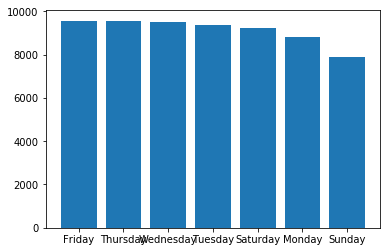

In [67]:
open_days = Counter([kk for k in hours for kk in k])
open_days_sorted = sorted(open_days.items(), key=lambda x: x[1], reverse=True)

import matplotlib.pyplot as plt

plt.bar(x=[t[0] for t in open_days_sorted], height=[t[1] for t in open_days_sorted])
plt.show()

#### Most businesses open:
* ('Thursday', 9552)
* ('Friday', 9565)
* ('Wednesday', 9503)

#### Less businesses open:
* ('Sunday', 7912)
* ('Monday', 8824)

 <a class="anchor" id="example"></a>
Example Json:

    {'business_id': '5UmKMjUEUNdYWqANhGckJw',
     'full_address': '4734 Lebanon Church Rd\nDravosburg, PA 15034',
     'hours': {'Friday': {'close': '21:00', 'open': '11:00'},
       'Tuesday': {'close': '21:00', 'open': '11:00'},
       'Thursday': {'close': '21:00', 'open': '11:00'},
       'Wednesday': {'close': '21:00', 'open': '11:00'},
       'Monday': {'close': '21:00', 'open': '11:00'}},
     'open': True,
     'categories': ['Fast Food', 'Restaurants'],
     'city': 'Dravosburg',
     'review_count': 7,
     'name': 'Mr Hoagie',
     'neighborhoods': [],
     'longitude': -79.9007057,
     'state': 'PA',
     'stars': 3.5,
     'latitude': 40.3543266,
     'attributes': {'Take-out': True,
      'Drive-Thru': False,
      'Good For': {'dessert': False,
       'latenight': False,
       'lunch': False,
       'dinner': False,
       'brunch': False,
       'breakfast': False},
     'Caters': False,
    'Noise Level': 'average',
    'Takes Reservations': False,
    'Delivery': False,
    'Ambience': {'romantic': False,
      'intimate': False,
      'classy': False,
      'hipster': False,
      'divey': False,
      'touristy': False,
      'trendy': False,
      'upscale': False,
      'casual': False},
    'Parking': {'garage': False,
      'street': False,
      'validated': False,
      'lot': False,
      'valet': False},
    'Has TV': False,
    'Outdoor Seating': False,
    'Attire': 'casual',
    'Alcohol': 'none',
    'Waiter Service': False,
    'Accepts Credit Cards': True,
    'Good for Kids': True,
    'Good For Groups': True,
    'Price Range': 1},
    'type': 'business'}